In [2]:
#Libraries

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

***STEP 1: DATA COLLECTION***

1. Problem statement and data collection

Inspiration
What can we learn about different hosts and areas?
What can we learn from predictions? (ex: locations, prices, reviews, etc)
Which hosts are the busiest and why?
Is there any noticeable difference of traffic among different areas and what could be the reason for it?

In [3]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv")
df.head()



,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.to_csv("../data/raw/airbnb_data.csv", index = False)

***STEP 2: EXPLORATION AND DATA CLEANING***

In [5]:
def check_data(df):
    print("Dataset informations:")
    print(df.info())
    print("\Dataset dimensions")
    print("\nMissing values ​​by column:")
    print(df.isna().sum()[df.isna().sum()>0])

check_data(df)


Dataset informations:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_revie

##### Statements

* This DataFame is composed by 48 895 rows and 16 columns (variables). 
* The variables "last_review" (10052 nulls) and "reviews_per_month" (10052 nulls) only have 38 843 instances with values, so it would contain more than 10000 null values. The variables "name" (16 nulls)  and "host_name" (21 nulls) also have null values, but in a much smaller number than the previous two. The rest of the variables always have a value. 
* The data has:
    * **10 numerical variables** - id, host_id, latitude, longitude, price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count and availability_365.
    * **6 categorical variables** - name, host_name, neighbourhood_group, neighbourhood, room_type and last_review.

*****Eliminate duplicates*****

I decided to analyze the duplicates in the "id" column, since this variable must be unique, to does not "hide" the duplicates in the other columns.


* Looking for duplicated IDs and dropping them, if any.

In [6]:
df['id'].duplicated().sum()

np.int64(0)

* Any duplicate values were found. 

In [7]:
#df.drop("id", axis =1).duplicated().sum()

****Eliminate irrelevant information****

In [8]:
df.drop(["id", "name", "host_id", "host_name", "last_review", "reviews_per_month"], axis = 1, inplace = True)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


##### Statement

The algorithm will not use these variables - id, name, host_id host_name, last_review, reviews_per_month - in the predictive process; so can be considered non essential to make a prediction. 

Reasoning behind dropping these variables from the data:

* **id, name, host_id and host_name** - these features are mainly identifiers in our database and can not be influence the frequency of rentals at each location; and as was statement above, the variables "name" and "host_name" have null values.

* **last_review and reviews_per_month** - since we lack additional dates to connect with this feature, we opted to remove it. The relevant information regarding reviews is already represented in our DataFrame by the 'number_of_reviews' column.

***STEP 3: ANALYSIS OF UNIVARIATE VARIABLES***

#### Analysis of categorical variables

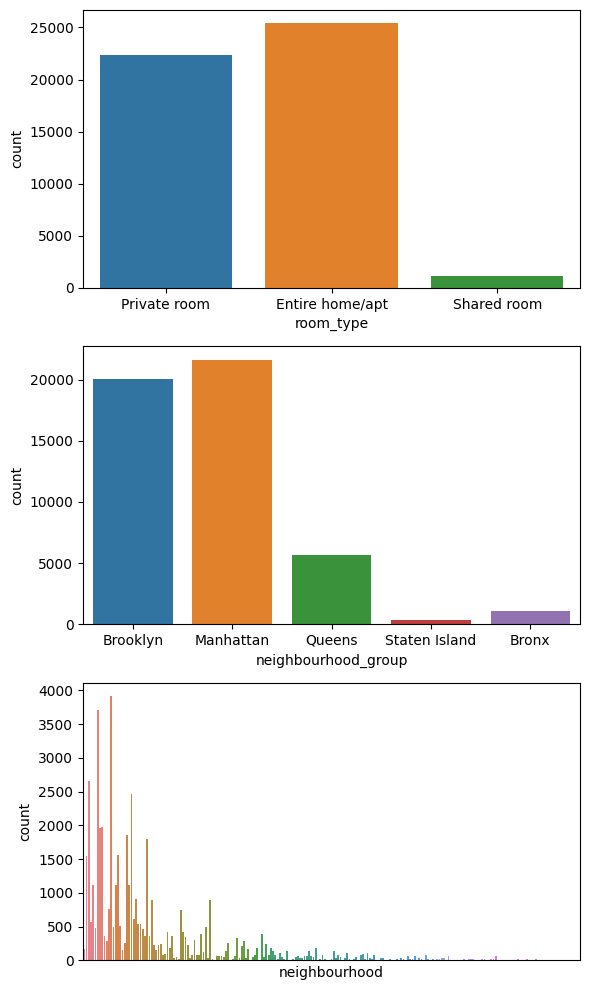

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(3, 1, figsize = (6, 10))
sns.countplot(ax= ax[0], data = df, x = "room_type", hue='room_type')
sns.countplot(ax = ax[1], data = df, x = "neighbourhood_group", hue='neighbourhood_group')
sns.countplot(ax = ax[2], data = df, x = 'neighbourhood', hue='neighbourhood')
plt.xticks(rotation=90, fontsize=6)

ax[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide x-axis labels

plt.tight_layout()
plt.show()


#### Statements 
With the representation of each variable by plotting their histogram, it's possible to determine that:

* ****room_type**** - this variable shows that most listings are for Private room and Entire home/apt, which is expected, as this offers more privacy and comfort to guests.

* ****neighbourhood_group**** - this variable shows a unequal distribution. Most properties are concentrated in Brooklyn and Manhattan, reflecting the higher demand and real estate value in these central areas, as well as their tourist and commercial appeal, compared to Staten Island and Bronx.

* ****neighbourhood**** - the distribution suggests that some neighborhoods are much more popular for Airbnb rentals than others. This could be due to tourist appeal, ease of access to public transportation, or simply the number of available listings. The long tail of the distribution suggests that most neighborhoods have few listings, with demand concentrated in a few highly popular neighborhoods.



#### Analysis on numeric variables

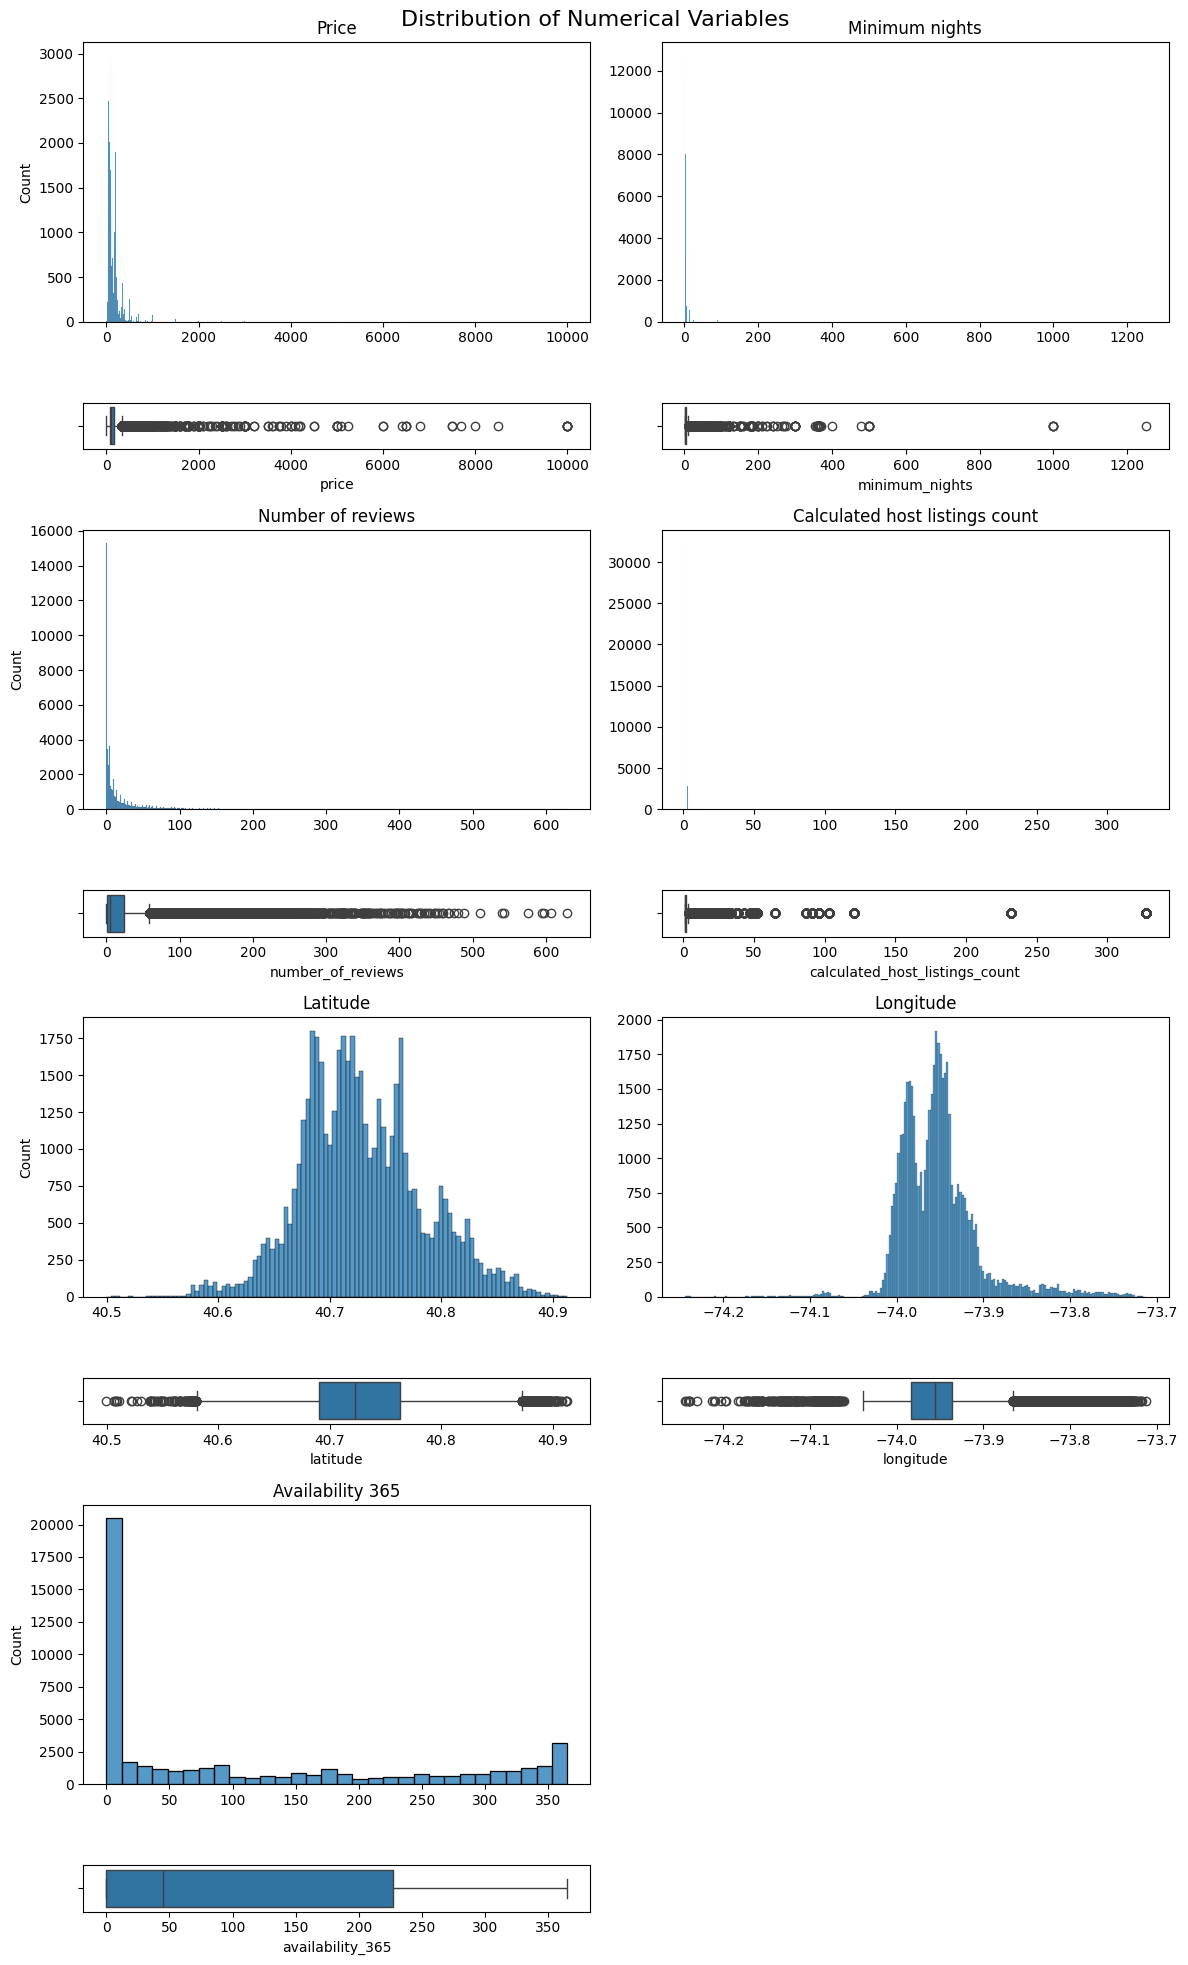

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axis = plt.subplots(8, 2, figsize=(12, 20), gridspec_kw={"height_ratios": [6, 1, 6, 1, 6, 1, 6, 1]})
plt.suptitle('Distribution of Numerical Variables', fontsize=16)

# Create histograms and boxplots for each variable

# Price
sns.histplot(ax=axis[0, 0], data=df, x="price").set(xlabel=None, title="Price")
sns.boxplot(ax=axis[1, 0], data=df, x="price")

# Minimum Nights
sns.histplot(ax=axis[0, 1], data=df, x="minimum_nights").set(xlabel=None, ylabel=None, title="Minimum nights")
sns.boxplot(ax=axis[1, 1], data=df, x="minimum_nights")

# Number of Reviews
sns.histplot(ax=axis[2, 0], data=df, x="number_of_reviews").set(xlabel=None, title="Number of reviews")
sns.boxplot(ax=axis[3, 0], data=df, x="number_of_reviews")

# Calculated Host Listings Count
sns.histplot(ax=axis[2, 1], data=df, x="calculated_host_listings_count").set(xlabel=None, ylabel=None, title="Calculated host listings count")
sns.boxplot(ax=axis[3, 1], data=df, x="calculated_host_listings_count")

# Latitude
sns.histplot(ax=axis[4, 0], data=df, x="latitude").set(xlabel=None, title="Latitude")
sns.boxplot(ax=axis[5, 0], data=df, x="latitude")

# Longitude
sns.histplot(ax=axis[4, 1], data=df, x="longitude").set(xlabel=None, ylabel=None, title="Longitude")
sns.boxplot(ax=axis[5, 1], data=df, x="longitude")

# Availability 365
sns.histplot(ax=axis[6, 0], data=df, x="availability_365").set(xlabel=None, title="Availability 365")
sns.boxplot(ax=axis[7, 0], data=df, x="availability_365")

# Remove the empty subplot
fig.delaxes(axis[7, 1])
fig.delaxes(axis[6, 1])

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


* to have a better visualization of the data distribution, I decide to graph a new version without outliers:

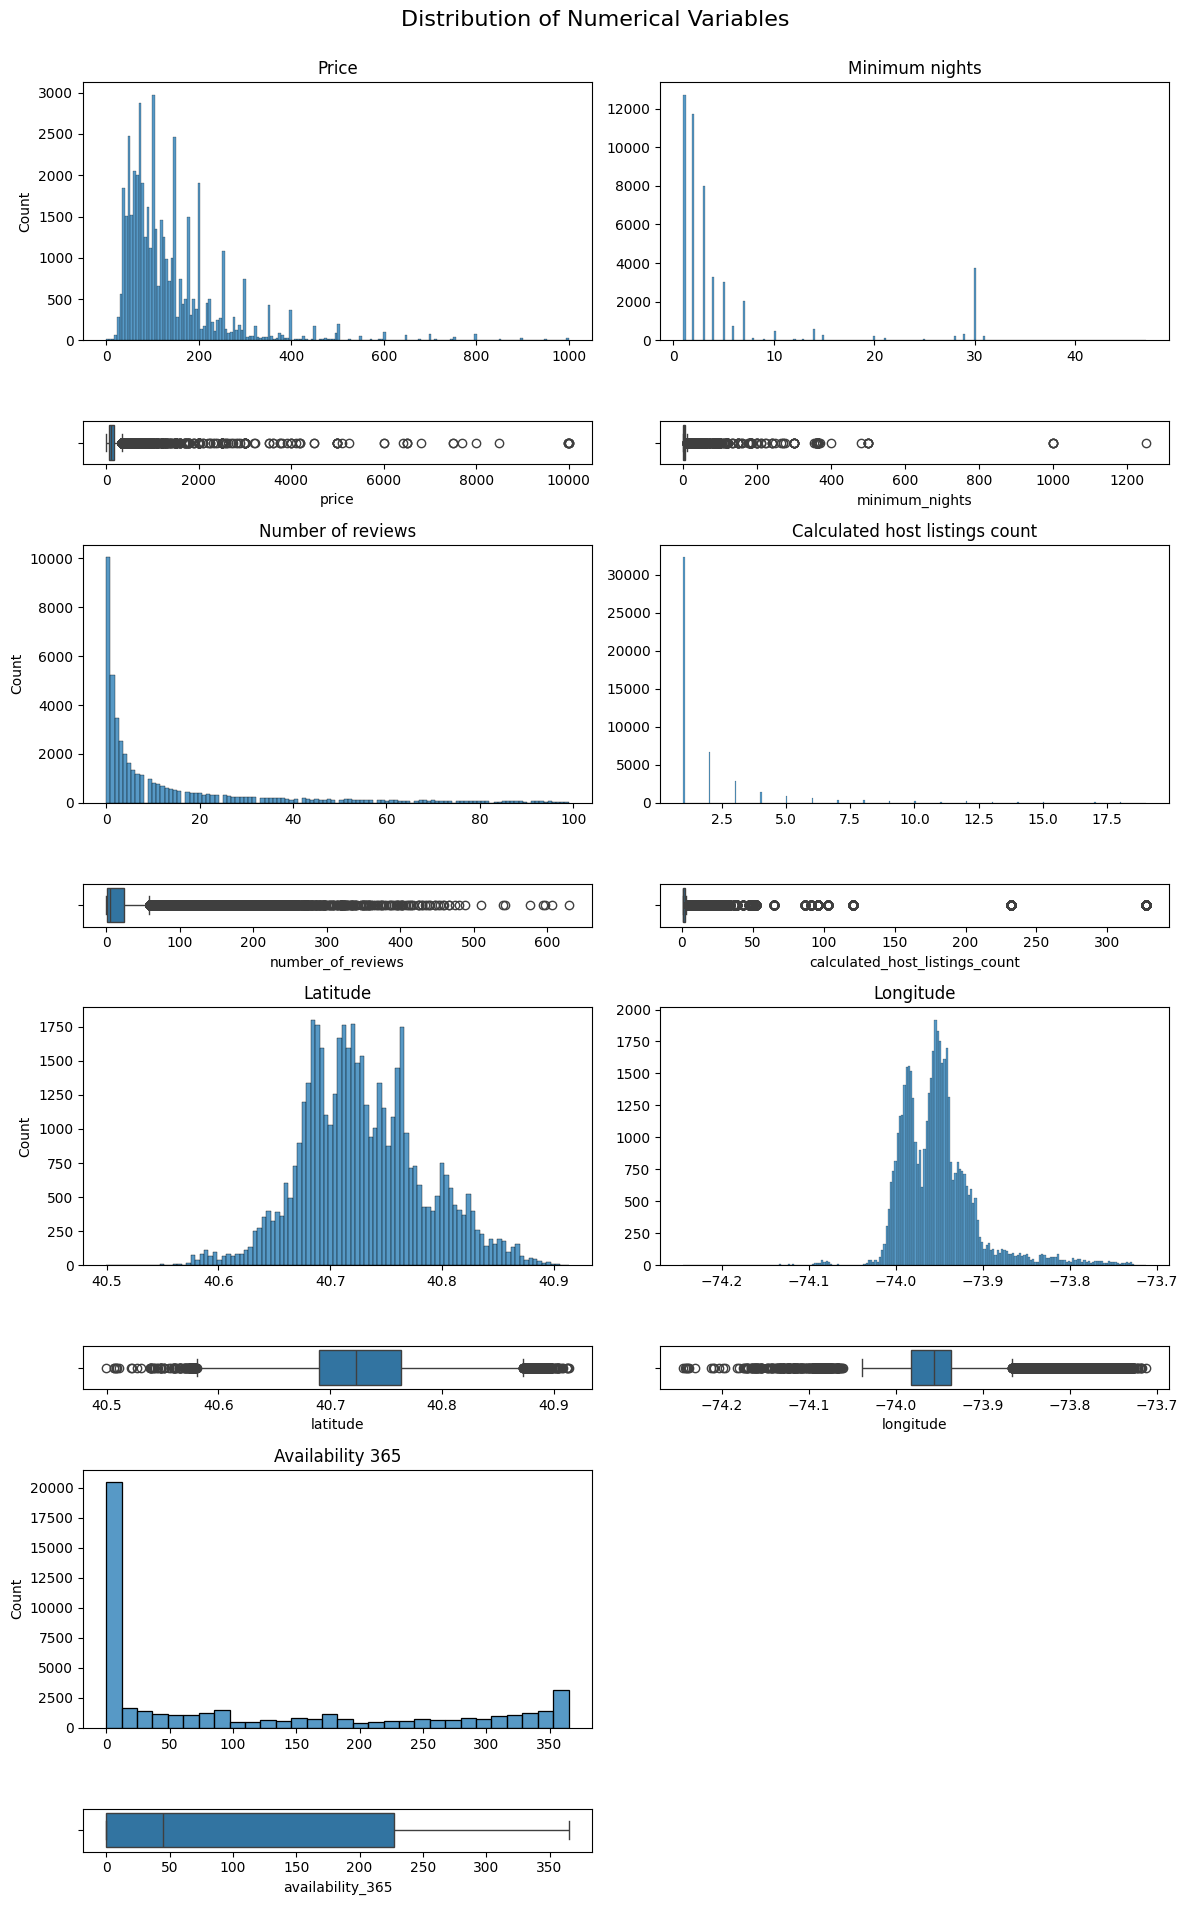

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axis = plt.subplots(8, 2, figsize=(12, 20), gridspec_kw={"height_ratios": [6, 1, 6, 1, 6, 1, 6, 1]})
plt.suptitle('Distribution of Numerical Variables', fontsize=16)

# Create histograms and boxplots for each variable

# Price
sns.histplot(ax=axis[0, 0], data=df[df["price"] < 1000], x="price").set(xlabel=None, title="Price")
sns.boxplot(ax=axis[1, 0], data=df, x="price")

# Minimum Nights
sns.histplot(ax=axis[0, 1], data=df[df["minimum_nights"] < 50], x="minimum_nights").set(xlabel=None, ylabel=None, title="Minimum nights")
sns.boxplot(ax=axis[1, 1], data=df, x="minimum_nights")

# Number of Reviews
sns.histplot(ax=axis[2, 0], data=df[df["number_of_reviews"] < 100], x="number_of_reviews").set(xlabel=None, title="Number of reviews")
sns.boxplot(ax=axis[3, 0], data=df, x="number_of_reviews")

# Calculated Host Listings Count
sns.histplot(ax=axis[2, 1], data=df[df["calculated_host_listings_count"] < 20], x="calculated_host_listings_count").set(xlabel=None, ylabel=None, title="Calculated host listings count")
sns.boxplot(ax=axis[3, 1], data=df, x="calculated_host_listings_count")

# Latitude
sns.histplot(ax=axis[4, 0], data=df, x="latitude").set(xlabel=None, title="Latitude")
sns.boxplot(ax=axis[5, 0], data=df, x="latitude")

# Longitude
sns.histplot(ax=axis[4, 1], data=df, x="longitude").set(xlabel=None, ylabel=None, title="Longitude")
sns.boxplot(ax=axis[5, 1], data=df, x="longitude")

# Availability 365
sns.histplot(ax=axis[6, 0], data=df, x="availability_365").set(xlabel=None, title="Availability 365")
sns.boxplot(ax=axis[7, 0], data=df, x="availability_365")

# Remove the empty subplot
fig.delaxes(axis[6, 1])
fig.delaxes(axis[7, 1])

# Adjust the layout to prevent overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

# Show the plot
plt.show()


#### Statements

 
* **Price:** this variable is central to modeling rental cost and helps identify luxury or economy listings; most listings are concentrated in lower price ranges, while only a few properties charge very high rates. This may indicate that the Airbnb market in New York is accessible for different budgets, though with some luxury or exclusive properties.

* **Minimum Nights:** this variable helps differentiate between posts geared towards short and long stays; the distribution shows that most hosts do not require a very high minimum number of nights.

* **Number of Reviews:** this variable indicates the popularity and frequency of use of properties; most listings have few reviews, suggesting that many properties may be new or have low popularity. However, listings with many reviews may indicate high-demand properties.

* **Calculated Host Listings Count:** this variable reflects the level of experience or professionalism of hosts, differentiating casual hosts from multi-property managers; most hosts have only one or a few properties, indicating that the Airbnb market in New York is largely dominated by small hosts. However, there are a few large hosts with many listings, suggesting the presence of professionals in the market.

* **Latitude and longitude:** geographic location tends to be one of the main factors influencing price and demand, especially in large cities. Properties in central areas or near tourist attractions tend to be more expensive. The histogram shows that most Airbnb listings in New York are in central or popular areas. This analysis suggests that this variable may be important in predicting price and popularity, as listings closer to the center or high-demand areas are likely to be more valuable.

* **Availability_365:** the bimodal distribution of availability suggests that most properties have low availability, pointing to occasional rentals, while a smaller subset remains open year-round, likely managed by professional hosts. So, this indicates a mix of dedicated hosts and potentially seasonal or inactive listings.

***STEP 4: ANALYSIS OF MULTIVARIATE VARIABLES***

#### Numerical-numerical analysis

Since we are faced with an Airbnb dataset, the variable of interest for this bivariate analysis could be **price**, as it is a ***continuous numerical*** variable that is ***central*** to the context of accommodation. Analyzing how price varies in relation to other variables can help us understand which factors most influence rental prices.

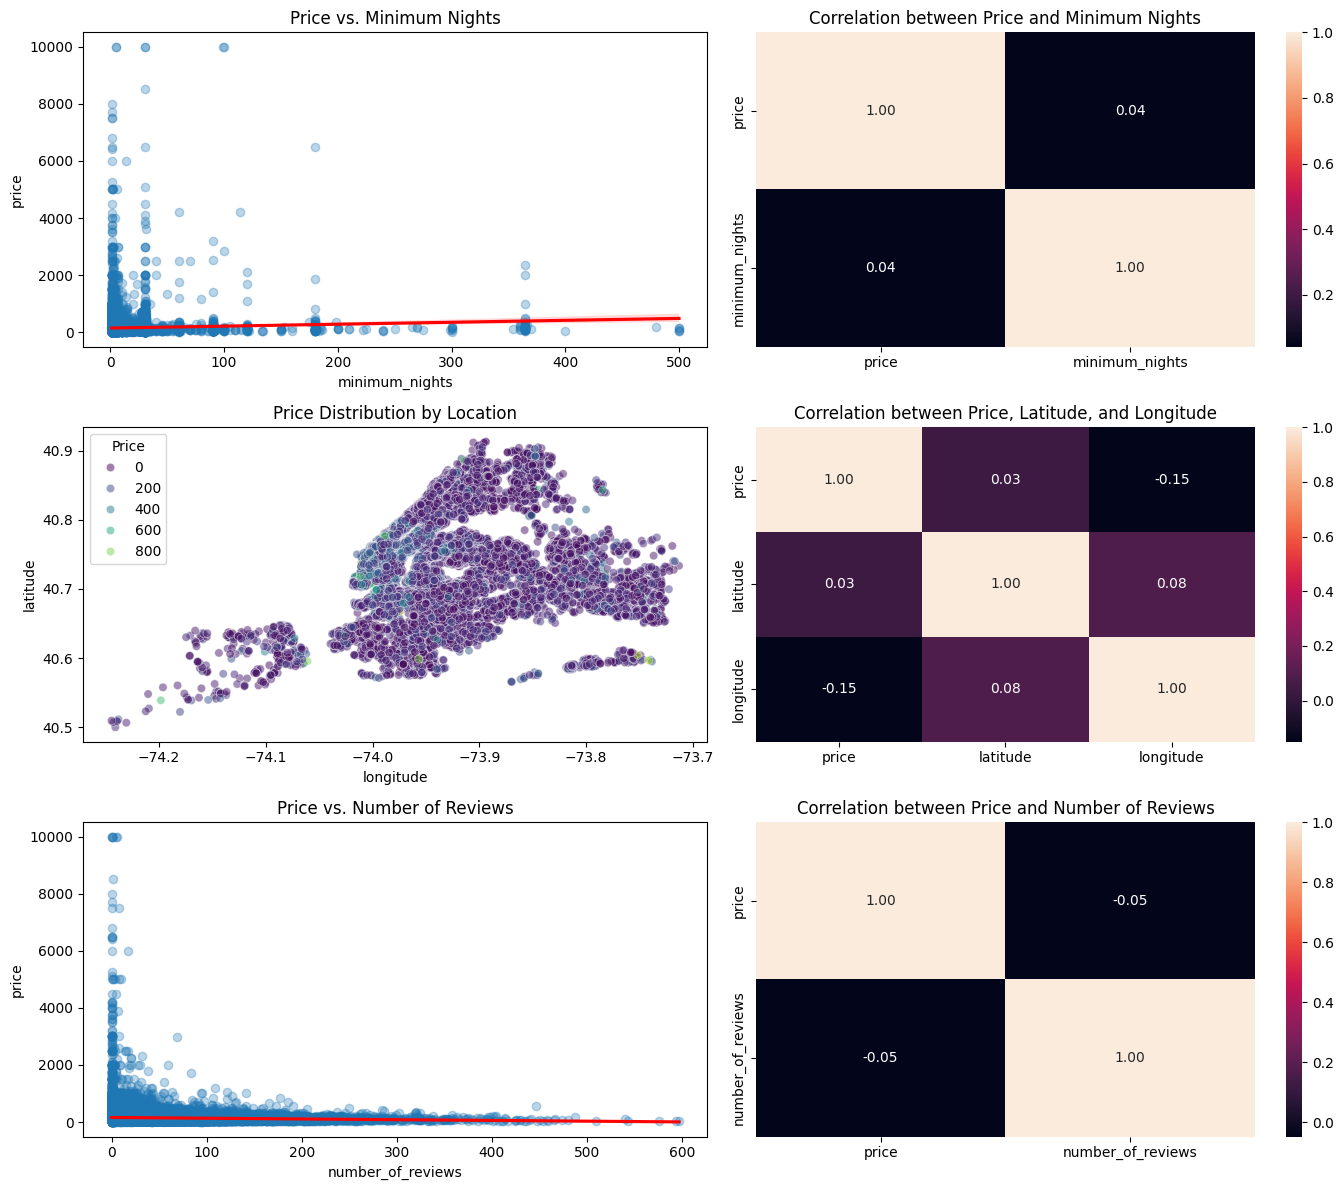

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(14, 12))

# 1. Scatter plot: Price vs. Minimum Nights with regression line
plt.subplot(3, 2, 1)
sns.regplot(data=df[df["minimum_nights"] < 600], x='minimum_nights', y='price', 
            scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Price vs. Minimum Nights')

#2. Correlation Heatmap for Price and Minimum Nights
plt.subplot(3, 2, 2)
corr_min_nights_price = df[['price', 'minimum_nights']].corr()
sns.heatmap(corr_min_nights_price, annot=True, fmt=".2f", cbar=True)
plt.title('Correlation between Price and Minimum Nights')

# 3. Scatter plot: Price vs. Location (Latitude and Longitude)
plt.subplot(3, 2, 3)
sns.scatterplot(data=df[df["price"] < 1000], x='longitude', y='latitude', hue='price', palette='viridis', alpha=0.5)
plt.title('Price Distribution by Location')
plt.legend(title='Price')

# 4. Correlation Heatmap for Latitude and Longitude
plt.subplot(3, 2, 4)
corr_lat_long_price = df[['price', 'latitude', 'longitude']].corr()
sns.heatmap(corr_lat_long_price, annot=True, fmt=".2f", cbar=True)
plt.title('Correlation between Price, Latitude, and Longitude')

# 5. Scatter plot: Price vs. Number of Reviews with regression line
plt.subplot(3, 2, 5)
sns.regplot(data=df[df["number_of_reviews"] < 600], x='number_of_reviews', y='price', 
            scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Price vs. Number of Reviews')

# 6. Correlation Heatmap for Price and Number of Reviews
plt.subplot(3, 2, 6)
corr_reviews_price = df[['price', 'number_of_reviews']].corr()
sns.heatmap(corr_reviews_price, annot=True, fmt=".2f", cbar=True)
plt.title('Correlation between Price and Number of Reviews')

# Layout adjustment
plt.tight_layout()
plt.show()


#### Statements

**Price - Minimum Nights:**  
* most lower priced listings (around 2,000 and under) have a minimum number of nights ranging from 1 to 50.
* for minimum_nights values ​​above 100, prices tend to be lower, suggesting that listings with longer minimum stays offer reduced rates, possibly to attract longer stays.
* there is no relation between the **price** and **minimum nights**.

**Price Distribution by Location (Latitude vs. Longitude):** 
* the areas with the highest prices seem to be concentrated in the central region (where lighter colored dots represent higher values).
* the southernmost and most remote areas tend to have lower prices, which is common in cities where the urban center is valued.
* the geographic distribution confirms that location has a direct impact on prices, with central areas, close to points of interest, charging significantly higher prices.
* there is a slight negative correlation between **price** and **longitude**, suggesting that areas further west (closer to Manhattan) may have slightly higher prices. However, this ***correlation is very weak*** (-0.15).

**Price vs. Number of Reviews:** 
* most listings with a high number of reviews (over 100) are relatively low-priced, suggesting that more popular listings are those with more affordable rates.
* this distribution suggests an inverse relationship between price and number of reviews, indicating that lower-priced properties may be more popular or affordable, thus accumulating more reviews.
* there is no relation between the **price** and the **number of reviews**.

#### Categorical-Categorical analysis

* **Categorical variables in analysis:** 

    * room_type
    * neighbourhood
    * neighbourhood_group

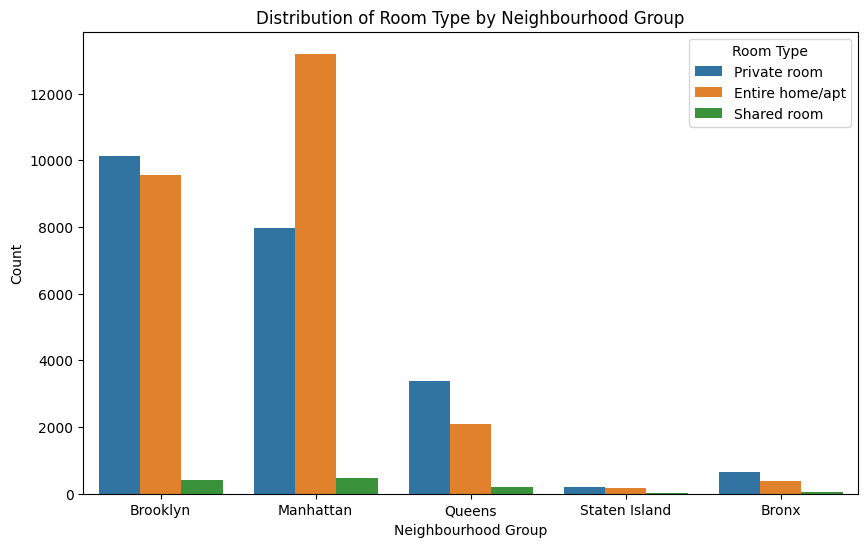

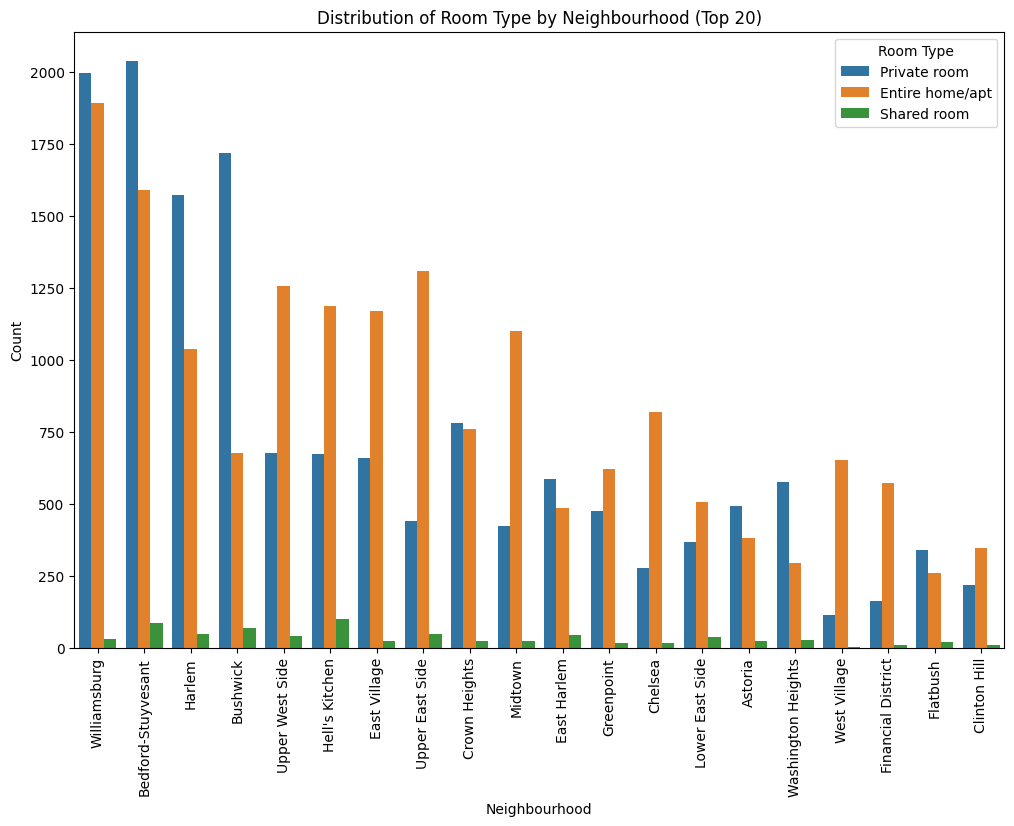

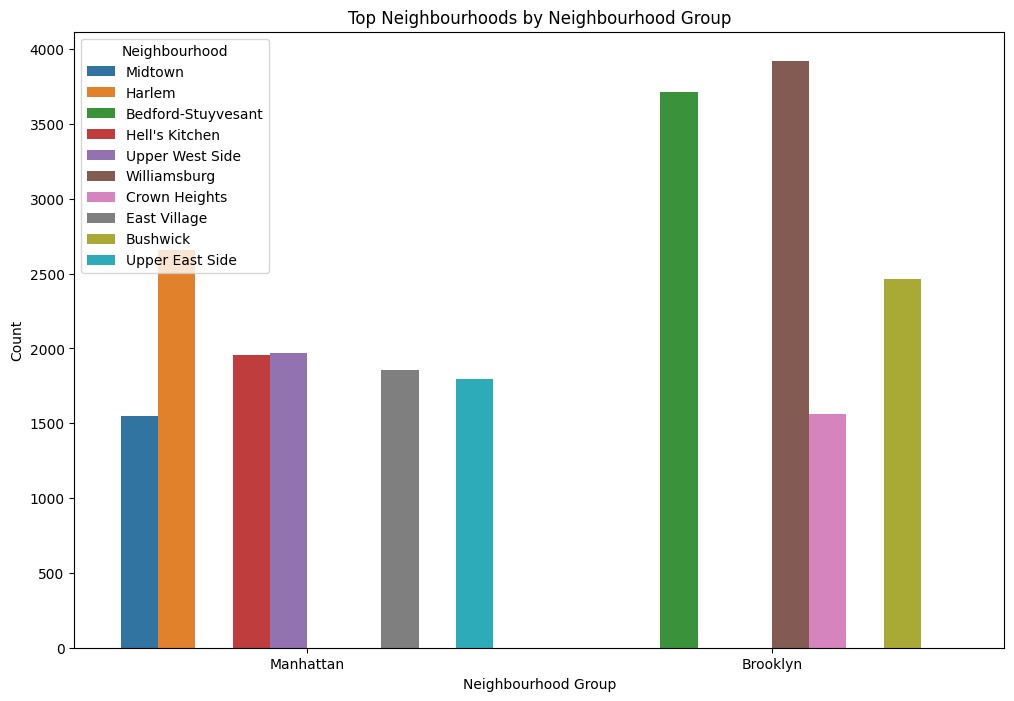

In [13]:
# 1. Countplot: Neighbourhood Group vs. Room Type
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='neighbourhood_group', hue='room_type')
plt.title('Distribution of Room Type by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Count')
plt.legend(title='Room Type')
plt.show()

# 2. Countplot: Neighbourhood vs. Room Type (focusing on individual neighbourhoods)
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='neighbourhood', hue='room_type', order=df['neighbourhood'].value_counts().index[:20])
plt.title('Distribution of Room Type by Neighbourhood (Top 20)')
plt.xlabel('Neighbourhood')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend(title='Room Type')
plt.show()

# 3. Countplot: Neighbourhood Group vs. Neighbourhood (top 10 neighbourhoods per group)
# Limiting to the top neighbourhoods in each group for clarity
top_neighbourhoods = df['neighbourhood'].value_counts().index[:10]
filtered_data = df[df['neighbourhood'].isin(top_neighbourhoods)]

plt.figure(figsize=(12, 8))
sns.countplot(data=filtered_data, x='neighbourhood_group', hue='neighbourhood')
plt.title('Top Neighbourhoods by Neighbourhood Group')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Count')
plt.legend(title='Neighbourhood', loc='upper left')
plt.show()



#### Statements

* Room Type Distribution: Entire home/apt is more common in tourist areas (especially Manhattan), while Private room is more prevalent in residential neighborhoods in Brooklyn.
* Rarity of Shared room: This type of accommodation is less common in all neighborhoods, suggesting a decrease in interest in shared stays.
* High Demand in Popular Areas: Neighborhoods such as Midtown and Williamsburg have a significant concentration of listings, reflecting their popularity and potential for short-term rentals.


#### From string to numerical transformation -> json saving

In [14]:
# Função genérica para fatorizar, salvar mapeamento e adicionar coluna ao DataFrame
def factorize_and_save(df, column_name, json_filename):
    # Fatoriza a coluna, obtendo valores únicos e codificados
    factorized_values, unique_values = pd.factorize(df[column_name])
    
    # Cria o dicionário de mapeamento
    parsing_dict = {str(unique_values[i]): int(factorized_values[factorized_values == i][0]) for i in range(len(unique_values))}
    
    # Salva o dicionário de mapeamento em JSON
    with open(json_filename, "w") as f:
        json.dump(parsing_dict, f)
    
    # Adiciona a coluna fatorada ao DataFrame
    df[column_name + "_n"] = factorized_values

# Aplicação da função para as colunas 'neighbourhood', 'neighbourhood_group' e 'room_type'
factorize_and_save(df, "neighbourhood", "neighbourhood_n.json")
factorize_and_save(df, "neighbourhood_group", "neighbourhood_group_n.json")
factorize_and_save(df, "room_type", "room_type_n.json")


In [15]:
df_n = df.copy()
df_n.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,neighbourhood_group_n,room_type_n
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365,0,0,0
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355,1,1,1
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365,2,1,0
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194,3,0,1
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0,4,1,1


In [16]:
# --- CÓDIGO PARA RECARREGAR E APLICAR O MAPEAMENTO A PARTIR DO JSON ---

# Carrega os mapeamentos JSON e aplica-os no DataFrame
with open("neighbourhood_n.json", "r") as f:
    neighbourhood_dict = json.load(f)
df_n["neighbourhood_n"] = df_n["neighbourhood"].map(neighbourhood_dict)

with open("neighbourhood_group_n.json", "r") as f:
    neighbourhood_group_dict = json.load(f)
df_n["neighbourhood_group_n"] = df_n["neighbourhood_group"].map(neighbourhood_group_dict)

with open("room_type_n.json", "r") as f:
    room_type_dict = json.load(f)
df_n["room_type_n"] = df_n["room_type"].map(room_type_dict)


In [17]:
df_n.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)
df_n.head(3)

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,neighbourhood_group_n,room_type_n
0,40.64749,-73.97237,149,1,9,6,365,0,0,0
1,40.75362,-73.98377,225,1,45,2,355,1,1,1
2,40.80902,-73.94190,150,3,0,1,365,2,1,0


#### CORRELATION MATRIX

#### Numerical-Categorical analysis (complete)

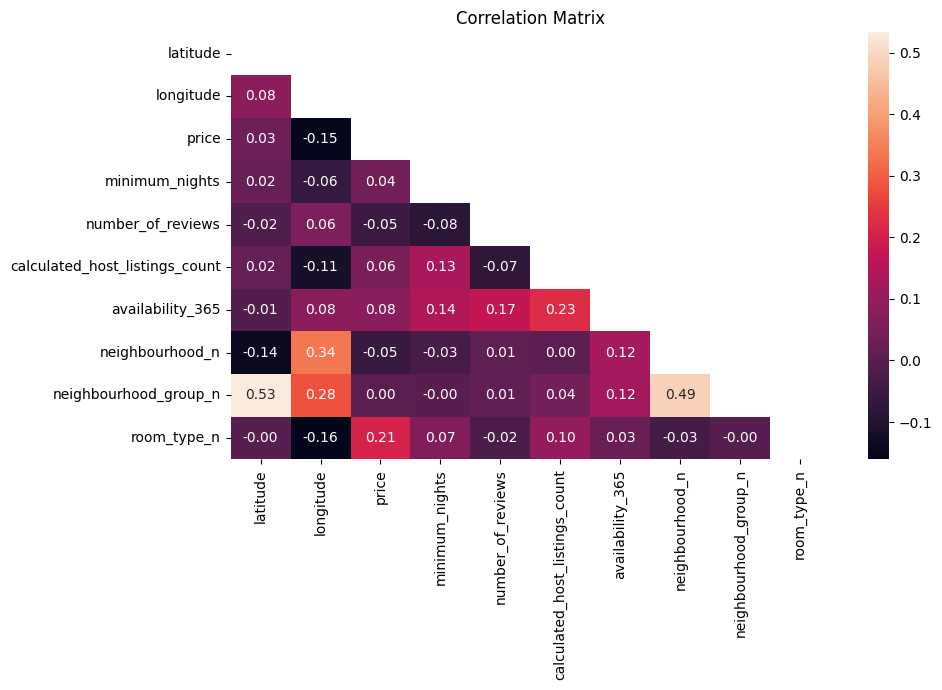

In [18]:
plt.figure(figsize=(10, 7))

sns.heatmap(df_n.corr(), annot=True, fmt=".2f", mask= np.triu(df_n.corr()))
plt.title("Correlation Matrix")

plt.tight_layout()
plt.show()



1. **Price and Room Type**:
   - There’s a positive correlation of 0.21 between `price` and `room_type_n`, indicating that different accommodation types influence price. This suggests that entire homes tend to be more expensive than private or shared rooms.

2. **Calculated Host Listings Count and Availability**:
   - `calculated_host_listings_count` and `availability_365` have a positive correlation of 0.23, suggesting that hosts with multiple listings tend to keep properties available for more days per year, indicating a higher presence of professional hosts.

3. **Neighbourhood Group and Neighbourhood**:
   - `neighbourhood_group_n` and `neighbourhood_n` show a strong positive correlation of 0.49, which is expected, as specific neighborhoods are grouped within larger neighborhood regions. This correlation reflects the dataset’s geographic structure.

4. **Minimum Nights and Availability**:
   - The correlation of 0.14 between `minimum_nights` and `availability_365` is weak, suggesting that, in some areas, higher minimum night requirements may be slightly associated with greater availability.

5. **Reviews and Availability**:
   - A correlation of 0.17 between `number_of_reviews` and `availability_365` suggests that listings available for more days tend to receive more reviews, likely due to more booking opportunities.

6. **Weak Correlation with Price**:
   - `price` shows low correlations with most other variables, except for a slight correlation with `room_type_n` (0.21). This suggests that price may be influenced by other property characteristics not represented in this dataset.

7. **Other Weak Correlations**:
   - Most other variables show very weak or near-zero correlations with each other, indicating low interdependence between categorical and numerical variables in the dataset.



#### Analysing all the variables

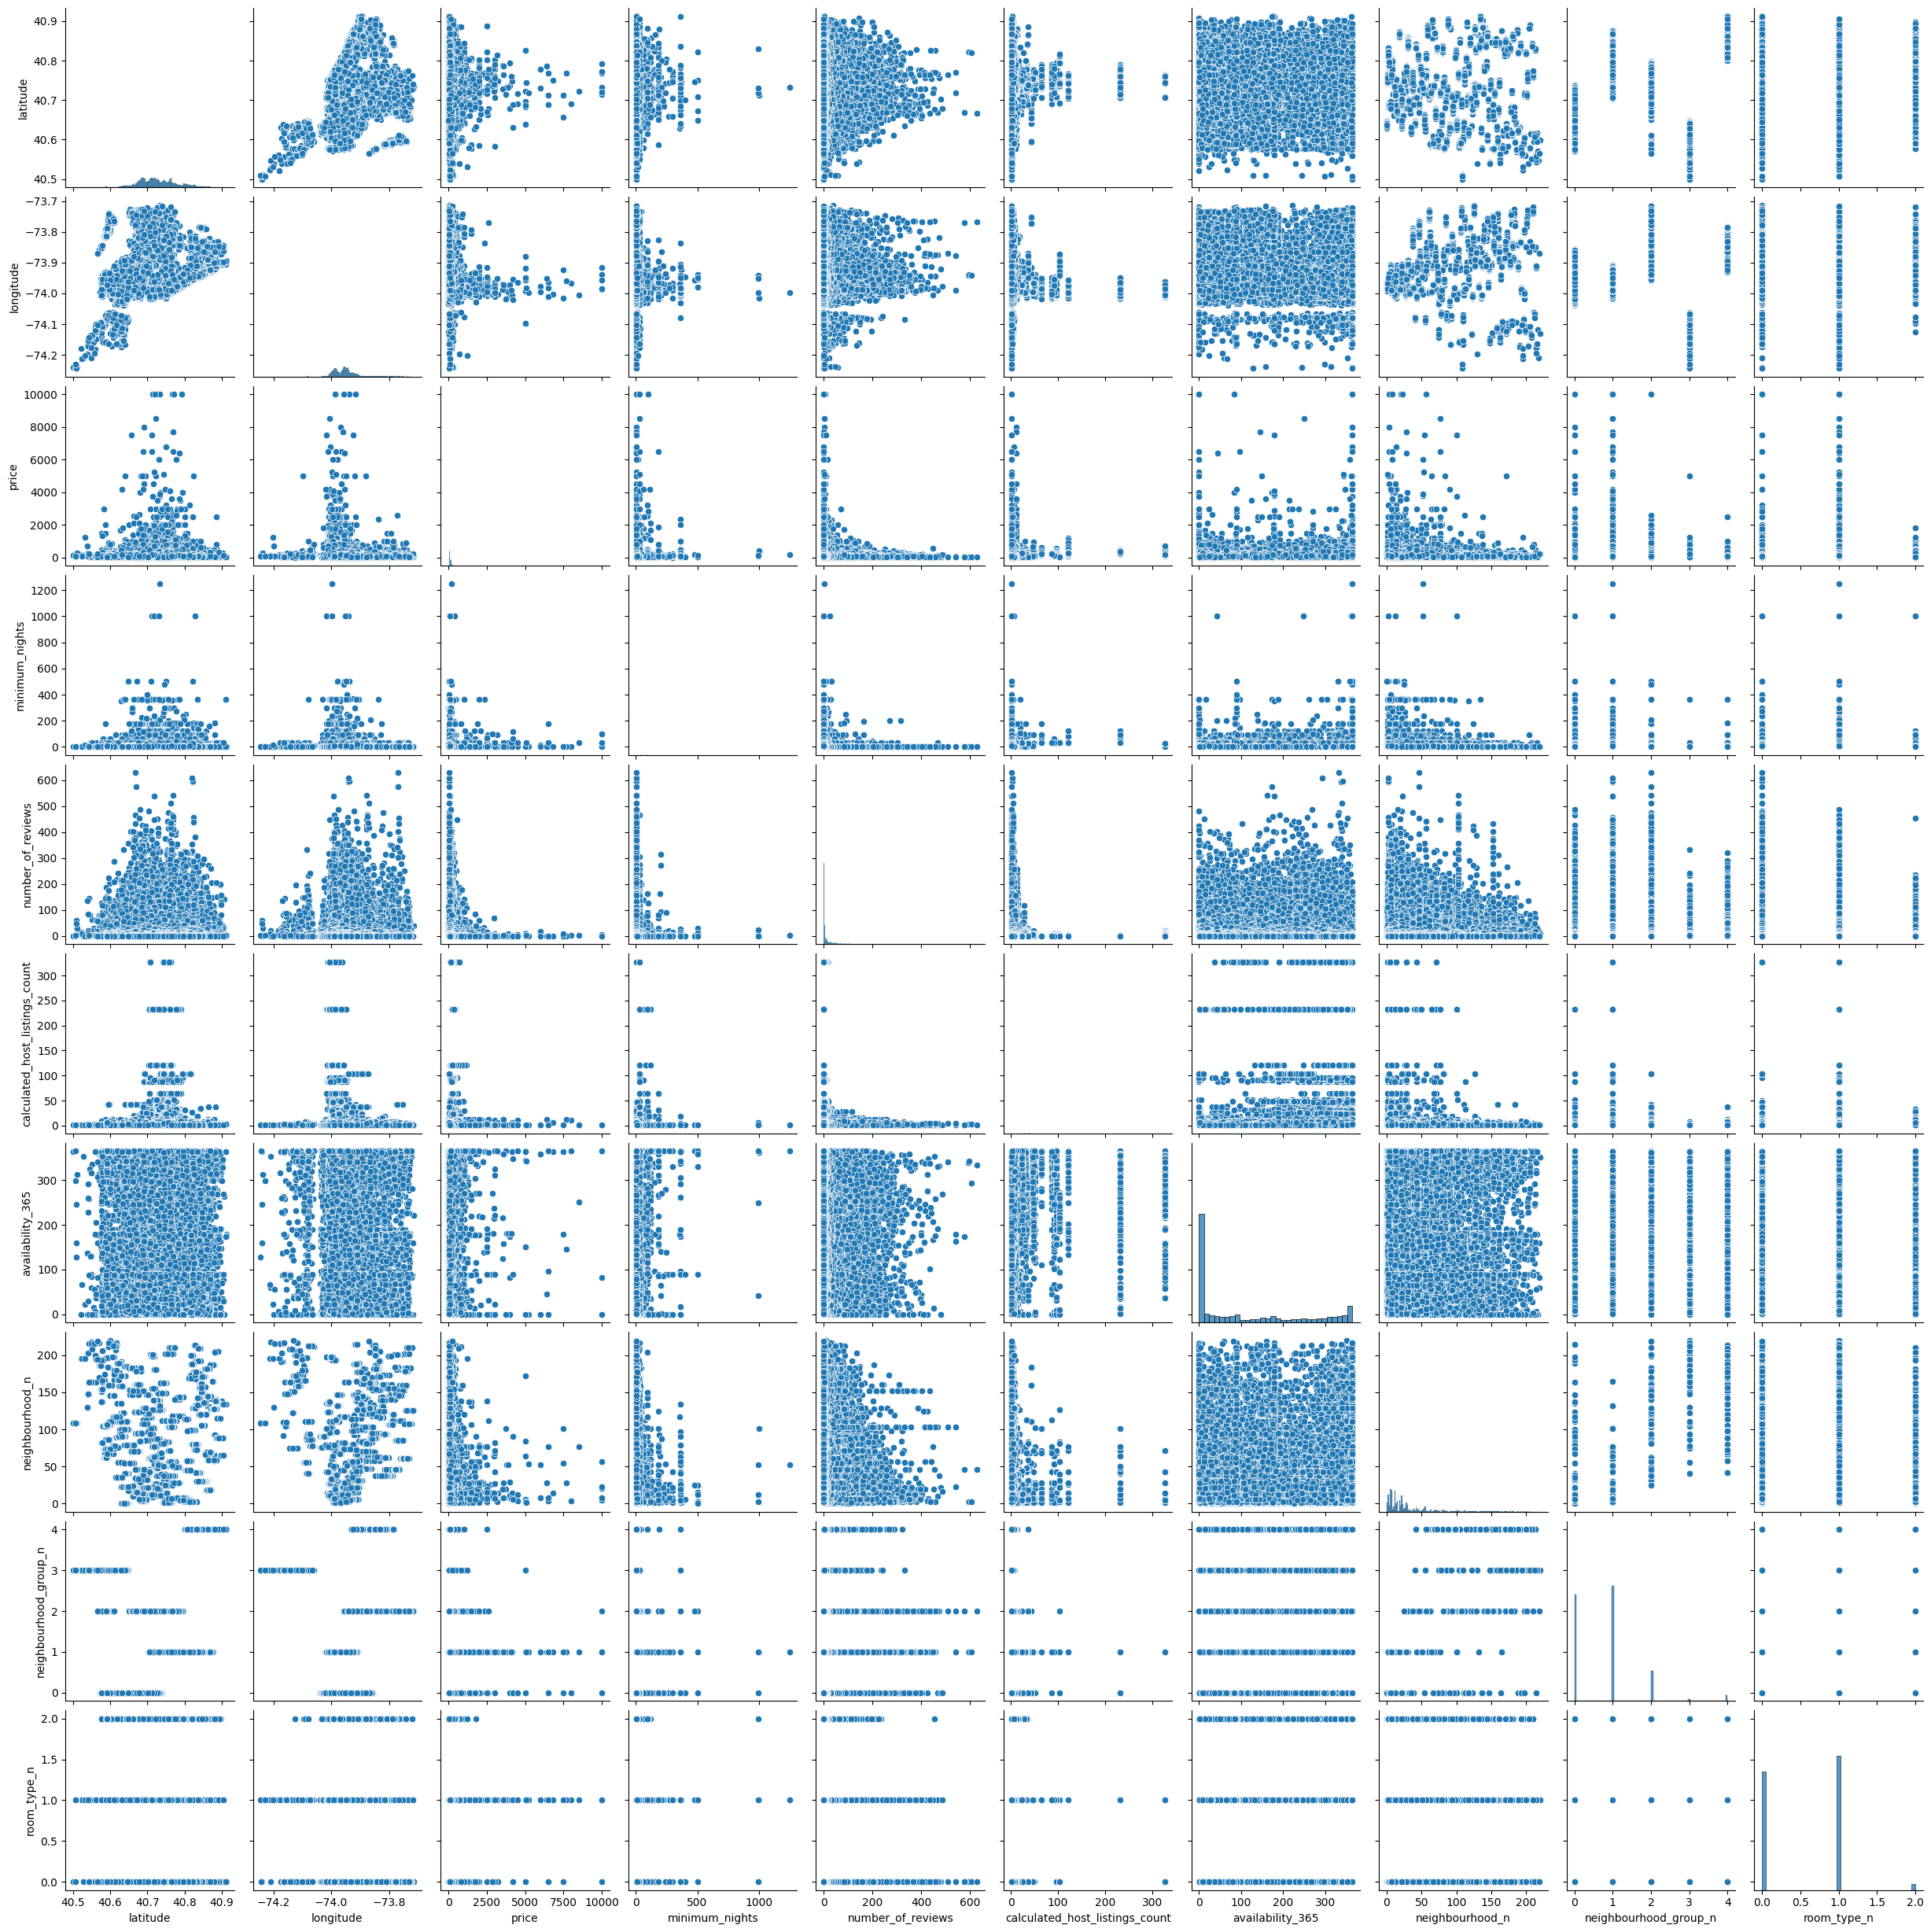

In [19]:
sns.pairplot(data = df_n)

***STEP 5: FEATURE ENGINEERING***

In [20]:
df_stats = df_n.describe()
df_stats

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,neighbourhood_group_n,room_type_n
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,112.781327,29.888782,0.786911,0.567113
std,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,131.622289,34.676634,0.844386,0.541249
min,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000,7.500000,0.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000,19.000000,1.000000,1.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,227.000000,37.000000,1.000000,1.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000,220.000000,4.000000,2.000000


Based on the descriptive statistics, it is possible to observe that:
* **mean-** The mean is affected by extremely high values ​​in all variables, suggesting that the data has many outliers;

* **Standard deviation-** The high variability confirms the presence of outliers, since the standard deviation is very high in relation to the means and central values, which suggests that the data is quite dispersed;

* **min-** The minimum values ​​seem reasonable and reflect the typical behavior of listings with minimum stay requirements and of varying popularity;

* **25%, 50% and 75%-** The quartiles indicate a very uneven distribution, especially in the minimum_nights and calculated_host_listings_count variables, with a large number of values ​​close to the upper limits, probably from large property managers or accommodations with exceptional requirements;

* **max-** The maximum values ​​are unrealistically high, which confirms the presence of extreme outliers that distort the overall metrics.

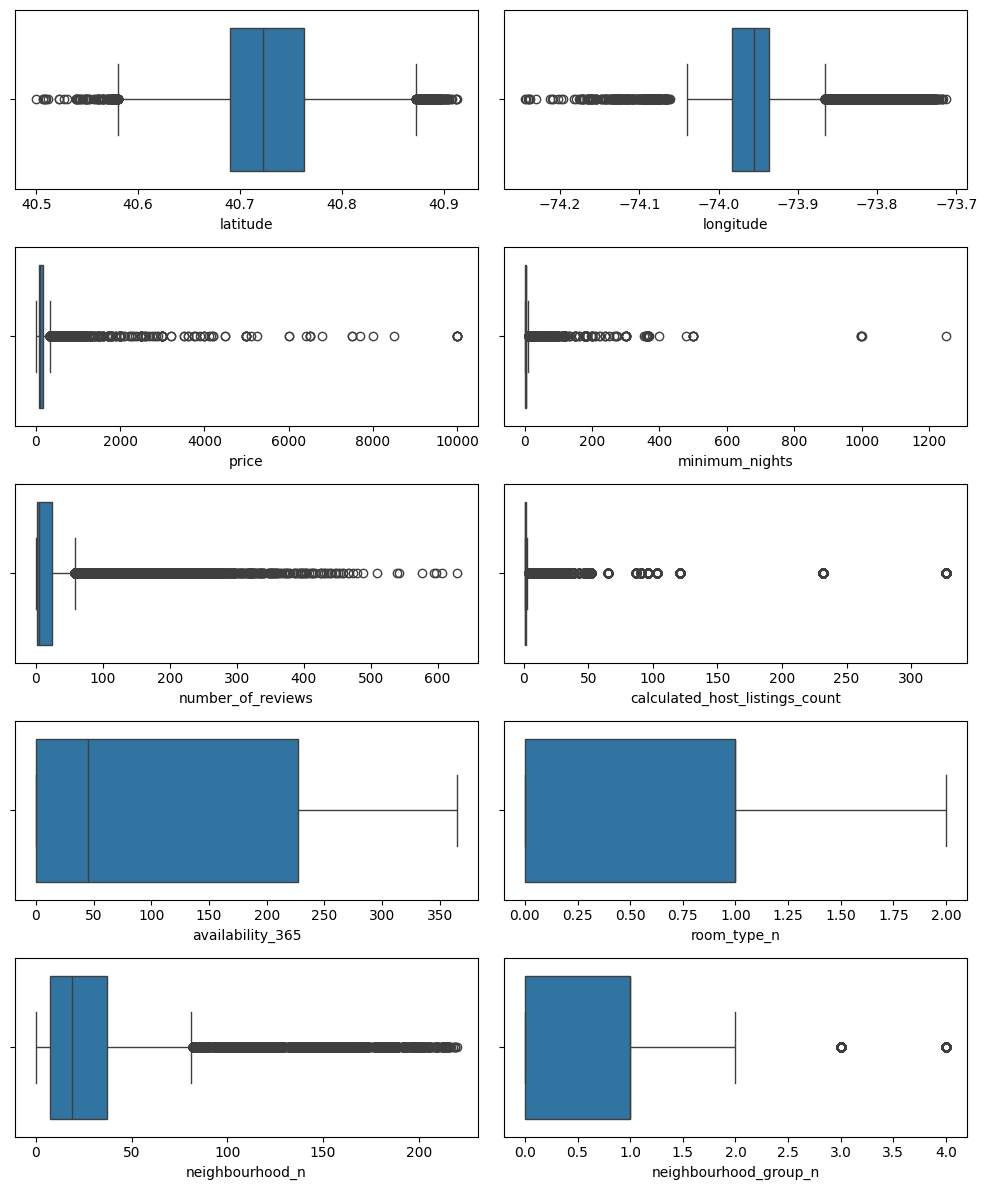

In [21]:
fig, ax = plt.subplots(5, 2, figsize=(10, 12))

sns.boxplot(ax = ax[0,0], data = df_n, x='latitude')
sns.boxplot(ax = ax[0,1], data = df_n, x='longitude')

sns.boxplot(ax = ax[1,0], data = df_n, x='price')
sns.boxplot(ax = ax[1,1], data = df_n, x='minimum_nights')

sns.boxplot(ax = ax[2,0], data = df_n, x='number_of_reviews')
sns.boxplot(ax = ax[2,1], data = df_n, x='calculated_host_listings_count')

sns.boxplot(ax = ax[3,0], data = df_n, x='availability_365')
sns.boxplot(ax = ax[3,1], data = df_n, x='room_type_n')

sns.boxplot(ax = ax[4,0], data = df_n, x='neighbourhood_n')
sns.boxplot(ax = ax[4,1], data = df_n, x='neighbourhood_group_n')

plt.tight_layout()
plt.show()

The following variables are essential for outlier treatment, as they are important for understanding price behavior, listing popularity, and host profiles:
* **minimum_nights** - To better reflect the reality of most stays without excessive requirements.
* **number_of_reviews** - To ensure that highly popular listings do not distort demand analyses.
* **calculated_host_listings_count** - To distinguish between casual hosts and large property managers.

### Outlier Analysis

In [22]:
df_with_outliers = df_n.copy()
df_without_outliers = df_n.copy()

In [23]:
# This function returns our new df without outliers and the features' limits.  
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*2)
    lower_lim = q1 - (iqr*2) if allow_neg else max(0, q1 - (iqr * 2))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))
    
    # Diretório base relativo para a pasta 'interim'
    base_path = os.path.join('data', 'interim')
    
    # Certifique-se de que o diretório 'processed' existe antes de salvar os arquivos
    os.makedirs('./enc', exist_ok=True)

    # Save the limits to a JSON file
    filename = f'/workspaces/RitaViegas---machine-learning-python-template/data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x



In [24]:
df_without_outliers['minimum_nights'] = remove_outliers(df_without_outliers['minimum_nights'], 'minimum_nights')
df_without_outliers['number_of_reviews'] = remove_outliers(df_without_outliers['number_of_reviews'], 'number_of_reviews')
df_without_outliers['calculated_host_listings_count'] = remove_outliers(df_without_outliers['calculated_host_listings_count'], 'calculated_host_listings_count')


### Missing Values

In [25]:
df_with_outliers.isnull().sum()

latitude                          0
longitude                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
neighbourhood_n                   0
neighbourhood_group_n             0
room_type_n                       0
dtype: int64

#### Statement
As we can see, there are no missing values.

### Inference of new features


In the context of Exploratory Data Analysis (EDA) for lodging data, creating new variables can be particularly relevant to understanding patterns of behavior, profitability, and popularity. Here are the ones I consider most important:

* **Occupancy rate-** to understand which listings are in highest demand. Since the number of reviews can be an indirect indication of booking frequency, occupancy_rate helps identify listings that are most popular and frequently occupied throughout the year.

* **Revenue estimate-** allows you to get an idea of ​​the financial potential of each listing. In a market analysis context, this variable can help identify the most profitable areas and types of accommodation.

Creating the new variables in both DataFrames (df_with_outliers and df_without_outliers). This way, each DataFrame will have the derived variables, and you can compare the results with and without the outliers.

In [26]:
# Creating "Occupancy rate" variable
df_with_outliers['occupancy_rate'] = (df_with_outliers['number_of_reviews'] / df_with_outliers['availability_365']) * 100
df_without_outliers['occupancy_rate'] = (df_without_outliers['number_of_reviews'] / df_without_outliers['availability_365']) * 100


In [27]:
df_with_outliers.drop(columns=['number_of_reviews', 'availability_365'], inplace=True)
df_without_outliers.drop(columns=['number_of_reviews', 'availability_365'], inplace=True)

In [28]:
df_with_outliers.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,neighbourhood_n,neighbourhood_group_n,room_type_n,occupancy_rate
0,40.64749,-73.97237,149,1,6,0,0,0,2.465753
1,40.75362,-73.98377,225,1,2,1,1,1,12.676056
2,40.80902,-73.94190,150,3,1,2,1,0,0.000000
3,40.68514,-73.95976,89,1,1,3,0,1,139.175258
4,40.79851,-73.94399,80,10,1,4,1,1,inf


In [29]:
df_without_outliers.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,neighbourhood_n,neighbourhood_group_n,room_type_n,occupancy_rate
0,40.64749,-73.97237,149,1.0,4.0,0,0,0,2.465753
1,40.75362,-73.98377,225,1.0,2.0,1,1,1,12.676056
2,40.80902,-73.94190,150,3.0,1.0,2,1,0,0.000000
3,40.68514,-73.95976,89,1.0,1.0,3,0,1,36.082474
4,40.79851,-73.94399,80,10.0,1.0,4,1,1,inf


In [30]:
df_without_outliers.isnull().sum()

latitude                             0
longitude                            0
price                                0
minimum_nights                       0
calculated_host_listings_count       0
neighbourhood_n                      0
neighbourhood_group_n                0
room_type_n                          0
occupancy_rate                    4845
dtype: int64

In [31]:
def clean_data(df):
    # replace infinite values ​​with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # fill NaN values ​​with the column mean
    df.fillna(df.mean(), inplace=True)
    return df


In [32]:
df_with_outliers_clean = clean_data(df_with_outliers)
print(df_with_outliers_clean.head())

   latitude  longitude  price  minimum_nights  calculated_host_listings_count  \
0  40.64749  -73.97237    149               1                               6   
1  40.75362  -73.98377    225               1                               2   
2  40.80902  -73.94190    150               3                               1   
3  40.68514  -73.95976     89               1                               1   
4  40.79851  -73.94399     80              10                               1   

   neighbourhood_n  neighbourhood_group_n  room_type_n  occupancy_rate  
0                0                      0            0        2.465753  
1                1                      1            1       12.676056  
2                2                      1            0        0.000000  
3                3                      0            1      139.175258  
4                4                      1            1      102.212711  


In [33]:
df_without_outliers_clean = clean_data(df_without_outliers)
print(df_without_outliers_clean.head())

   latitude  longitude  price  minimum_nights  calculated_host_listings_count  \
0  40.64749  -73.97237    149             1.0                             4.0   
1  40.75362  -73.98377    225             1.0                             2.0   
2  40.80902  -73.94190    150             3.0                             1.0   
3  40.68514  -73.95976     89             1.0                             1.0   
4  40.79851  -73.94399     80            10.0                             1.0   

   neighbourhood_n  neighbourhood_group_n  room_type_n  occupancy_rate  
0                0                      0            0        2.465753  
1                1                      1            1       12.676056  
2                2                      1            0        0.000000  
3                3                      0            1       36.082474  
4                4                      1            1       77.656156  


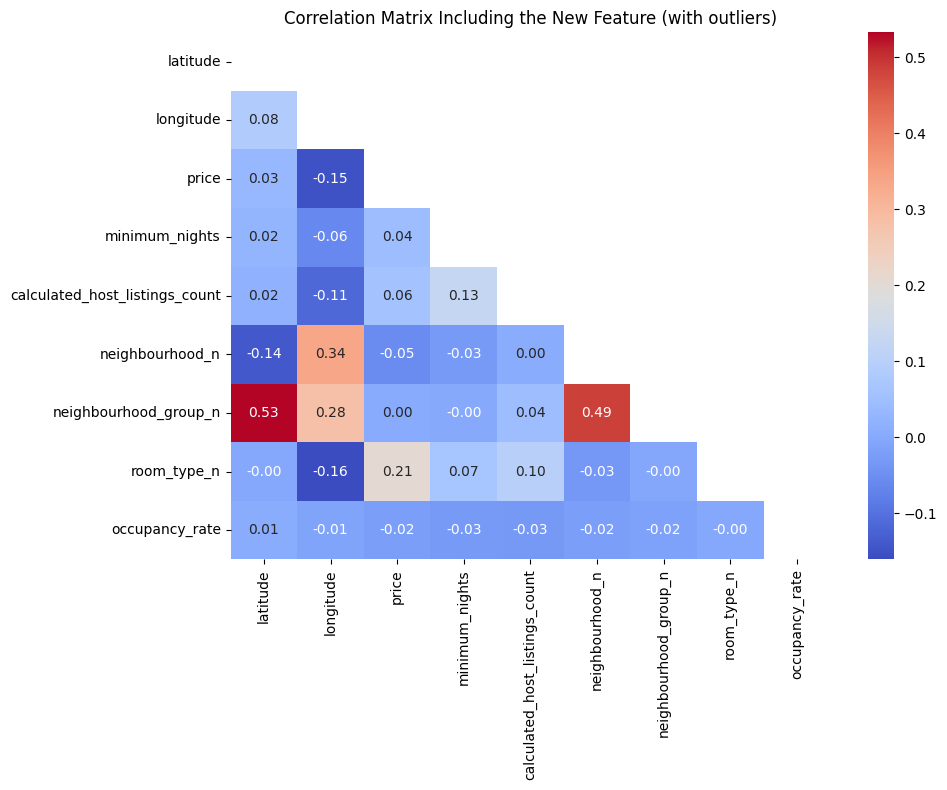

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_with_outliers_clean.corr(), annot=True, fmt=".2f",  cmap="coolwarm", mask= np.triu(df_with_outliers_clean.corr()))
plt.title("Correlation Matrix Including the New Feature (with outliers)")
plt.tight_layout()
plt.show()

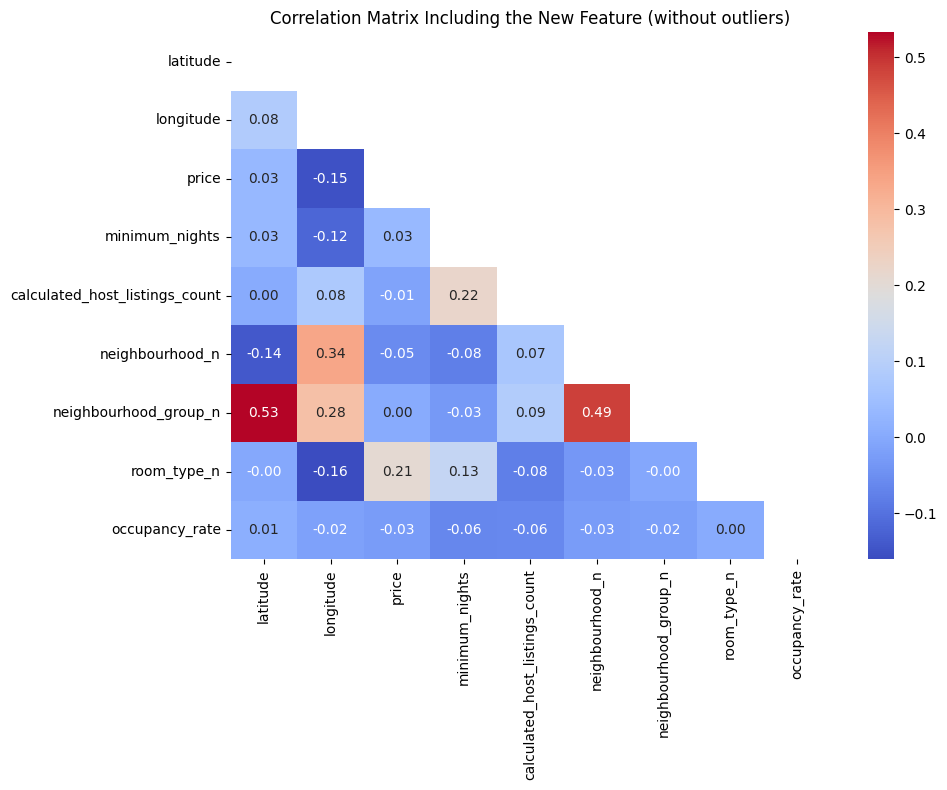

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_without_outliers_clean.corr(), annot=True, fmt=".2f",  cmap="coolwarm", mask= np.triu(df_without_outliers_clean.corr()))
plt.title("Correlation Matrix Including the New Feature (without outliers)")
plt.tight_layout()
plt.show()

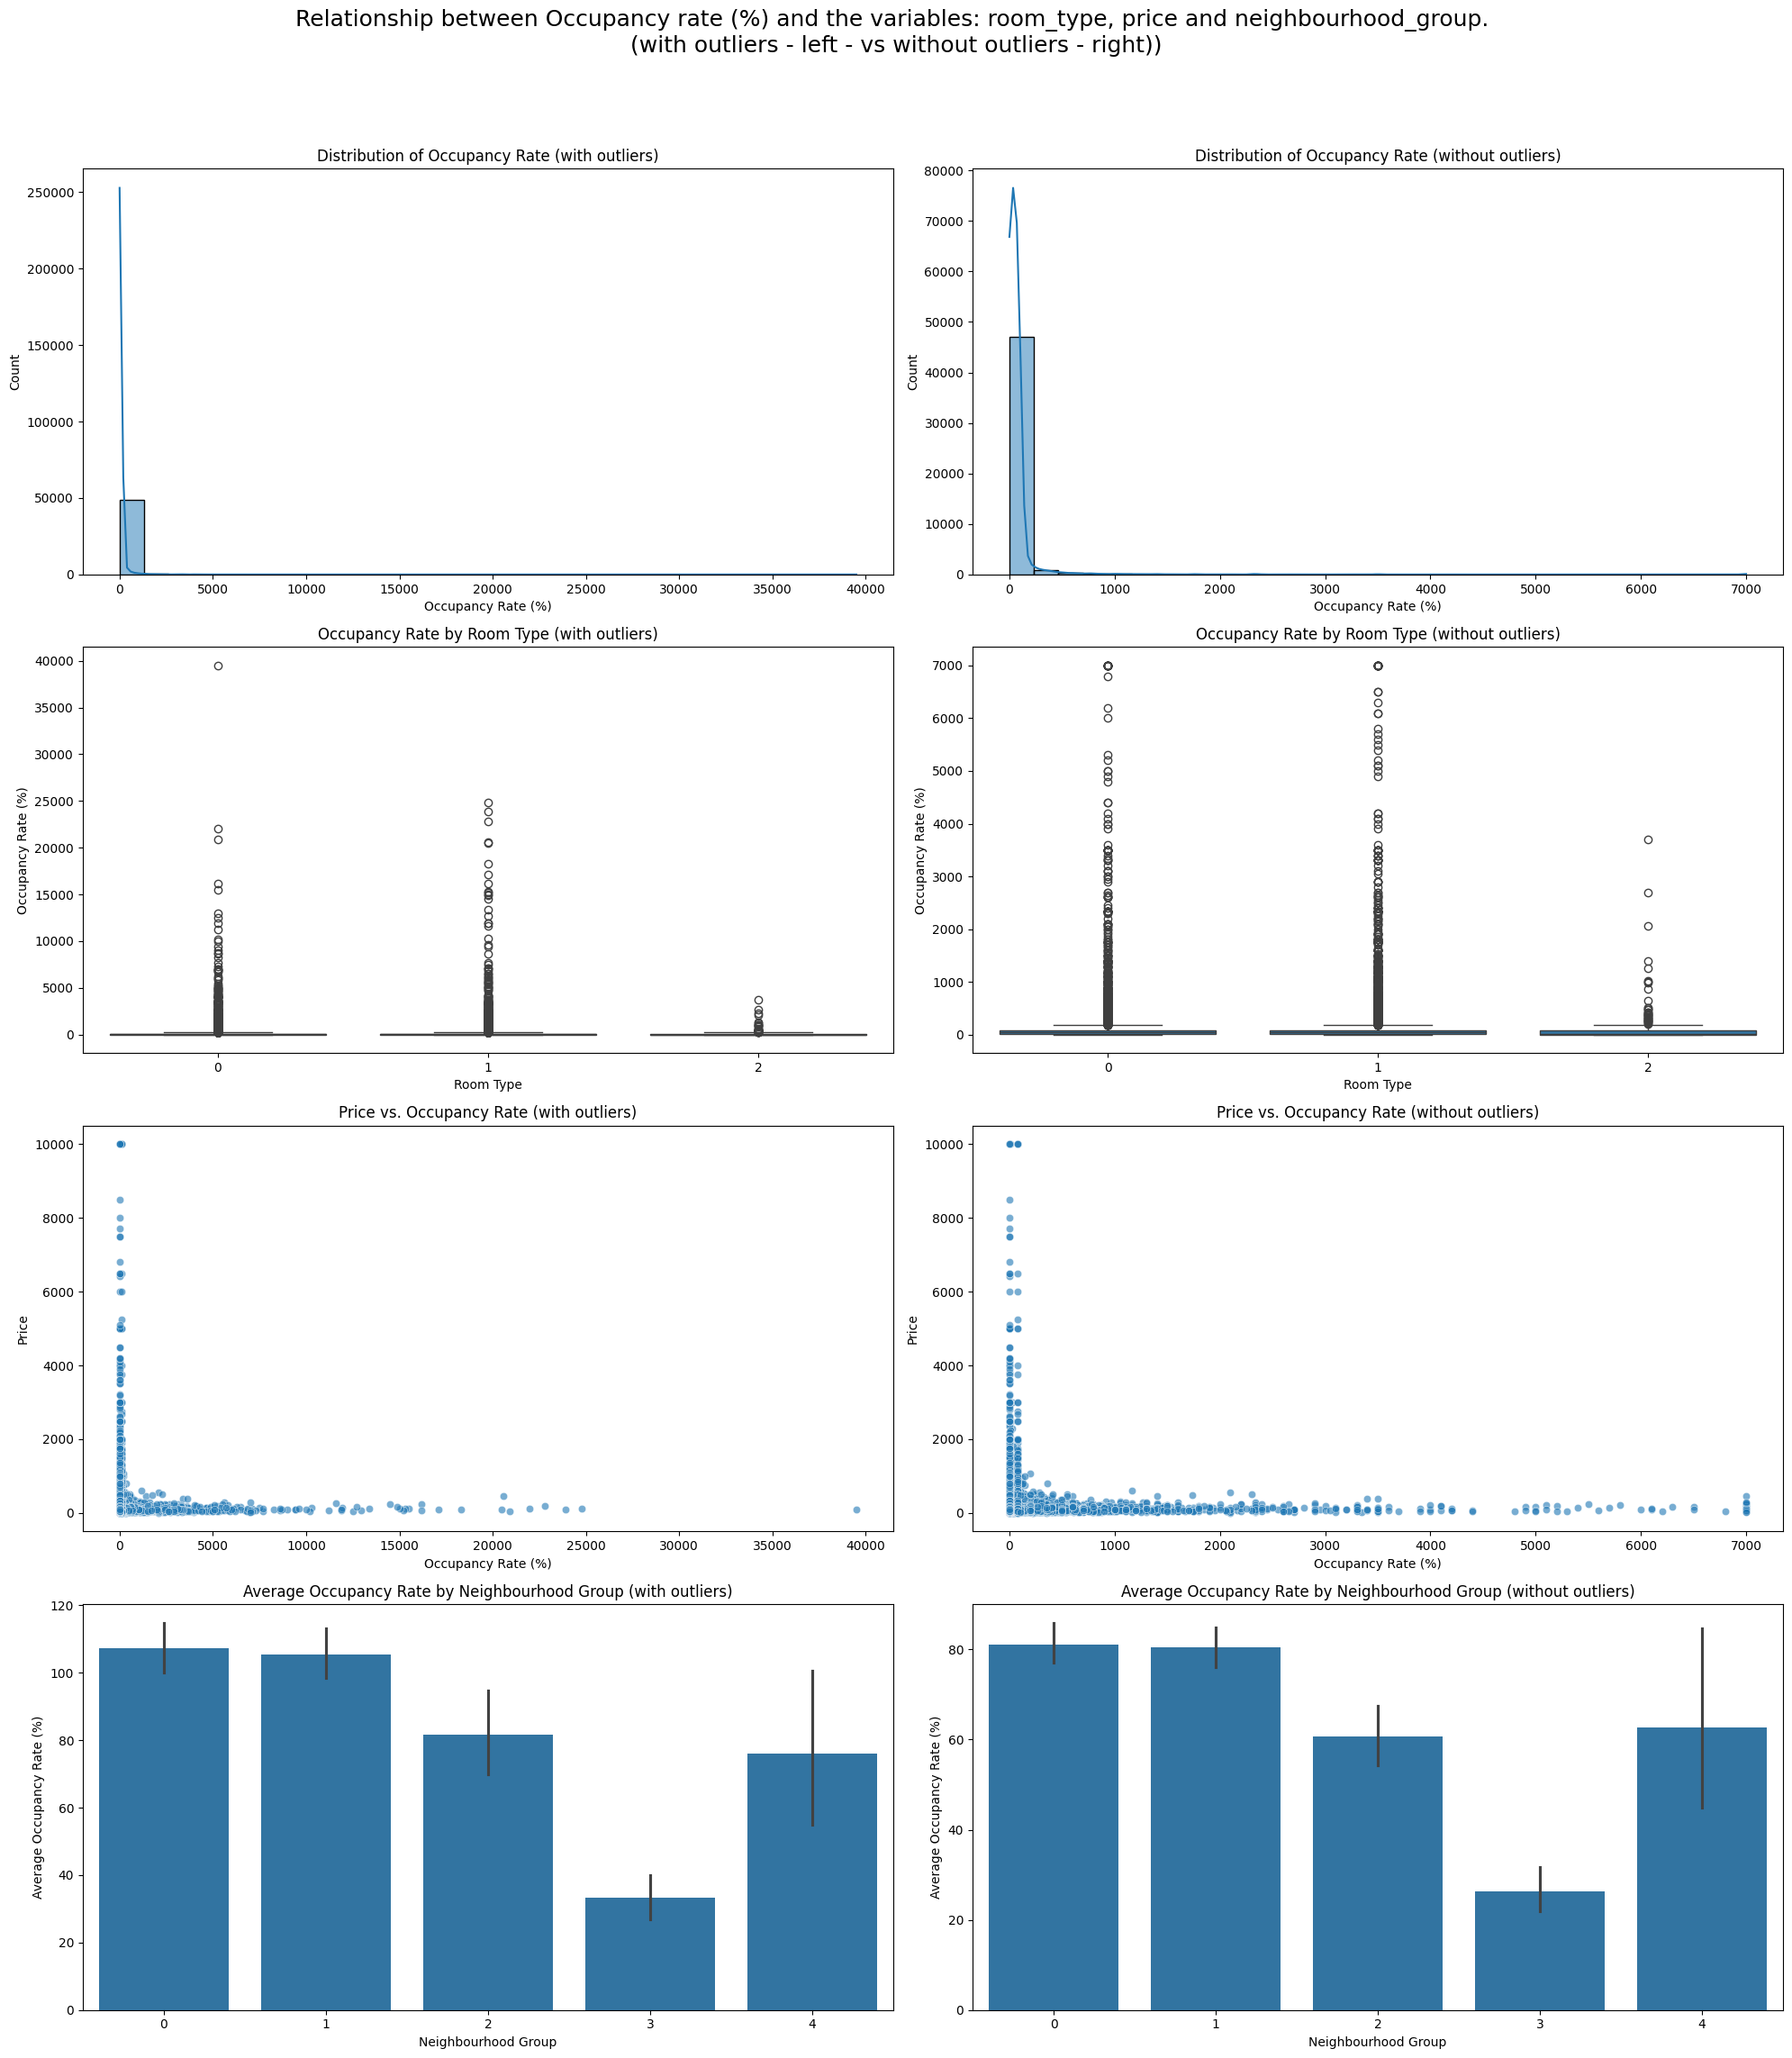

In [36]:
# Configuração da figura e layout (4 linhas, 2 colunas)
fig, axes = plt.subplots(4, 2, figsize=(20, 24))
fig.suptitle("Relationship between Occupancy rate (%) and the variables: room_type, price and neighbourhood_group. \n(with outliers - left - vs without outliers - right))", fontsize=18)

# 1. Distribution of Occupancy Rate
# Com Outliers - Esquerda
sns.histplot(df_with_outliers_clean['occupancy_rate'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Occupancy Rate (with outliers)')
axes[0, 0].set_xlabel('Occupancy Rate (%)')
axes[0, 0].set_ylabel('Count')

# Sem Outliers - Direita
sns.histplot(df_without_outliers_clean['occupancy_rate'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Occupancy Rate (without outliers)')
axes[0, 1].set_xlabel('Occupancy Rate (%)')
axes[0, 1].set_ylabel('Count')

# 2. Occupancy Rate by Room Type
# Com Outliers - Esquerda
sns.boxplot(data=df_with_outliers_clean, x='room_type_n', y='occupancy_rate', ax=axes[1, 0])
axes[1, 0].set_title('Occupancy Rate by Room Type (with outliers)')
axes[1, 0].set_xlabel('Room Type')
axes[1, 0].set_ylabel('Occupancy Rate (%)')

# Sem Outliers - Direita
sns.boxplot(data=df_without_outliers_clean, x='room_type_n', y='occupancy_rate', ax=axes[1, 1])
axes[1, 1].set_title('Occupancy Rate by Room Type (without outliers)')
axes[1, 1].set_xlabel('Room Type')
axes[1, 1].set_ylabel('Occupancy Rate (%)')

# 3. Price vs. Occupancy Rate
# Com Outliers - Esquerda
sns.scatterplot(data=df_with_outliers_clean, x='occupancy_rate', y='price', alpha=0.6, ax=axes[2, 0])
axes[2, 0].set_title('Price vs. Occupancy Rate (with outliers)')
axes[2, 0].set_xlabel('Occupancy Rate (%)')
axes[2, 0].set_ylabel('Price')

# Sem Outliers - Direita
sns.scatterplot(data=df_without_outliers_clean, x='occupancy_rate', y='price', alpha=0.6, ax=axes[2, 1])
axes[2, 1].set_title('Price vs. Occupancy Rate (without outliers)')
axes[2, 1].set_xlabel('Occupancy Rate (%)')
axes[2, 1].set_ylabel('Price')

# 4. Average Occupancy Rate by Neighbourhood Group
# Com Outliers - Esquerda
sns.barplot(data=df_with_outliers_clean, x='neighbourhood_group_n', y='occupancy_rate', estimator='mean', ax=axes[3, 0])
axes[3, 0].set_title('Average Occupancy Rate by Neighbourhood Group (with outliers)')
axes[3, 0].set_xlabel('Neighbourhood Group')
axes[3, 0].set_ylabel('Average Occupancy Rate (%)')

# Sem Outliers - Direita
sns.barplot(data=df_without_outliers_clean, x='neighbourhood_group_n', y='occupancy_rate', estimator='mean', ax=axes[3, 1])
axes[3, 1].set_title('Average Occupancy Rate by Neighbourhood Group (without outliers)')
axes[3, 1].set_xlabel('Neighbourhood Group')
axes[3, 1].set_ylabel('Average Occupancy Rate (%)')

# Ajuste do layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Statements** 

* The occupancy rate distribution is quite skewed, with most values ​​concentrated near zero. This indicates that most properties have a low occupancy rate, with a few exceptions that have extremely high rates.

* Private and shared rooms show higher outliers compared to private rooms, suggesting higher demand or usage.

* There is a concentration of low prices with high occupancy rates, indicating that more affordable listings tend to be in higher demand.

* Neighborhood groups 0 and 1 have the highest average occupancy rates, while group 3 has the lowest average rate. This variation suggests that geographic location has an impact on occupancy rate, with some neighborhoods being more popular than others.

In [37]:
df_with_outliers_clean.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,neighbourhood_n,neighbourhood_group_n,room_type_n,occupancy_rate
0,40.64749,-73.97237,149,1,6,0,0,0,2.465753
1,40.75362,-73.98377,225,1,2,1,1,1,12.676056
2,40.80902,-73.94190,150,3,1,2,1,0,0.000000
3,40.68514,-73.95976,89,1,1,3,0,1,139.175258
4,40.79851,-73.94399,80,10,1,4,1,1,102.212711


In [38]:
df_without_outliers_clean.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,neighbourhood_n,neighbourhood_group_n,room_type_n,occupancy_rate
0,40.64749,-73.97237,149,1.0,4.0,0,0,0,2.465753
1,40.75362,-73.98377,225,1.0,2.0,1,1,1,12.676056
2,40.80902,-73.94190,150,3.0,1.0,2,1,0,0.000000
3,40.68514,-73.95976,89,1.0,1.0,3,0,1,36.082474
4,40.79851,-73.94399,80,10.0,1.0,4,1,1,77.656156


### Split train/test of both Data Frames

In [39]:
# Função para dividir os dados em treino e teste
def split(target, df, test_size=0.2, random_state=123):
    """
    Divide um dataframe em conjuntos de treino e teste.
    
    Parâmetros:
    - target: string, coluna alvo que queremos prever
    - df: DataFrame, o dataframe completo que queremos dividir
    - test_size: float, tamanho do conjunto de teste
    - random_state: int, define a semente para reprodutibilidade
    - output_folder: string (opcional), pasta onde os arquivos CSV serão salvos. Se None, não salva.
    
    Retorna:
    - X_train, X_test, y_train, y_test: conjuntos de treino e teste
    """
    
    X = df.drop(columns=target)  # Remove a coluna alvo das features
    y = df[target]  # Define apenas a coluna alvo como y

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

# Aplicação da função split para dados com e sem outliers
X_train_with_outliers, X_test_with_outliers, y_train_with_outliers, y_test_with_outliers = split(
    target="price",
    df=df_with_outliers_clean
)

X_train_without_outliers, X_test_without_outliers, y_train_without_outliers, y_test_without_outliers = split(
    target="price",
    df=df_without_outliers_clean
)

# Diretório base relativo para a pasta 'processed'
base_path = os.path.join('data', 'processed')

# Certifique-se de que o diretório 'processed' existe antes de salvar os arquivos
os.makedirs(base_path, exist_ok=True)

# Exportar os dados de treino e teste para arquivos CSV usando caminhos relativos
X_train_with_outliers.to_csv(os.path.join(base_path, 'X_train_with_outliers.csv'), index=False)
X_test_with_outliers.to_csv(os.path.join(base_path, 'X_test_with_outliers.csv'), index=False)
y_train_with_outliers.to_csv(os.path.join(base_path, 'y_train.csv'), index=False)
y_test_with_outliers.to_csv(os.path.join(base_path, 'y_test.csv'), index=False)

X_train_without_outliers.to_csv(os.path.join(base_path, 'X_train_without_outliers.csv'), index=False)
X_test_without_outliers.to_csv(os.path.join(base_path, 'X_test_without_outliers.csv'), index=False)


In [40]:
# Visualizar os dados de treino e teste para verificação (opcional)
X_train_with_outliers.head()

,latitude,longitude,minimum_nights,calculated_host_listings_count,neighbourhood_n,neighbourhood_group_n,room_type_n,occupancy_rate
9601,40.70178,-73.92829,4,1,21,0,1,102.212711
45574,40.81157,-73.94654,3,1,2,1,1,0.000000
33996,40.79485,-73.97550,3,1,8,1,1,17.721519
11829,40.75997,-73.99265,2,1,7,1,1,102.212711
41134,40.67818,-73.92284,1,2,6,0,0,102.212711


In [41]:
y_train_with_outliers.head()

9601      98
45574    799
33996    146
11829    250
41134     55
Name: price, dtype: int64

### Normalization

In [42]:
def normalize_and_save(X_train, X_test, filename):
    """
    Normaliza os dados usando StandardScaler e salva o scaler para uso futuro.

    Parâmetros:
    - X_train: DataFrame com os dados de treino
    - X_test: DataFrame com os dados de teste
    - filename: string, o nome do arquivo para salvar o scaler

    Retorna:
    - X_train_norm: DataFrame com os dados de treino normalizados
    - X_test_norm: DataFrame com os dados de teste normalizados
    """

    scaler = StandardScaler()
    scaler.fit(X_train)  # Ajusta o scaler com os dados de treino

    # Aplica a normalização nos dados de treino e teste
    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    # Salva o scaler para uso futuro
    joblib.dump(scaler, f'./enc/{filename}.sav')

    return X_train_norm, X_test_norm

# Aplicação da função para normalizar dados com e sem outliers
X_train_with_outliers_norm, X_test_with_outliers_norm = normalize_and_save(
    X_train_with_outliers, X_test_with_outliers, 'normalized_with_outliers'
)

X_train_without_outliers_norm, X_test_without_outliers_norm = normalize_and_save(
    X_train_without_outliers, X_test_without_outliers, 'normalized_without_outliers'
)

# Verificação opcional para garantir que os dados foram normalizados e escalados corretamente
print(X_train_with_outliers_norm.head())
print(X_test_with_outliers_norm.head())


       latitude  longitude  minimum_nights  calculated_host_listings_count  \
9601  -0.499673   0.518943       -0.145443                       -0.185329   
45574  1.516461   0.123242       -0.193460                       -0.185329   
33996  1.209422  -0.504676       -0.193460                       -0.185329   
11829  0.568902  -0.876527       -0.241478                       -0.185329   
41134 -0.933052   0.637111       -0.289495                       -0.154982   

       neighbourhood_n  neighbourhood_group_n  room_type_n  occupancy_rate  
9601         -0.254377              -0.931080     0.799402       -0.002002  
45574        -0.802789               0.255707     0.799402       -0.186994  
33996        -0.629606               0.255707     0.799402       -0.154920  
11829        -0.658470               0.255707     0.799402       -0.002002  
41134        -0.687334              -0.931080    -1.047581       -0.002002  
       latitude  longitude  minimum_nights  calculated_host_listings_

### Min-Max Scaling

In [43]:
def minmax_and_save(X_train, X_test, filename):
    """
    Aplica Min-Max Scaling aos dados e salva o scaler para uso futuro.

    Parâmetros:
    - X_train: DataFrame com os dados de treino
    - X_test: DataFrame com os dados de teste
    - filename: string, o nome do arquivo para salvar o scaler

    Retorna:
    - X_train_minmax: DataFrame com os dados de treino escalados
    - X_test_minmax: DataFrame com os dados de teste escalados
    """

    scaler = MinMaxScaler()
    scaler.fit(X_train)  # Ajusta o scaler com os dados de treino

    # Aplica o Min-Max Scaling nos dados de treino e teste
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index=X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index=X_test.index, columns=X_test.columns)

    # Salva o scaler para uso futuro
    joblib.dump(scaler, f'./enc/{filename}.sav')

    return X_train_minmax, X_test_minmax

# Aplicação da função para escalar dados com e sem outliers
X_train_with_outliers_minmax, X_test_with_outliers_minmax = minmax_and_save(
    X_train_with_outliers, X_test_with_outliers, 'minmax_with_outliers'
)

X_train_without_outliers_minmax, X_test_without_outliers_minmax = minmax_and_save(
    X_train_without_outliers, X_test_without_outliers, 'minmax_without_outliers'
)

# Verificação opcional para garantir que os dados foram escalados corretamente
print(X_train_with_outliers_minmax.head())
print(X_test_with_outliers_minmax.head())


       latitude  longitude  minimum_nights  calculated_host_listings_count  \
9601   0.480438   0.594867        0.002402                        0.000000   
45574  0.750424   0.560525        0.001601                        0.000000   
33996  0.709308   0.506031        0.001601                        0.000000   
11829  0.623534   0.473759        0.000801                        0.000000   
41134  0.422403   0.605122        0.000000                        0.003067   

       neighbourhood_n  neighbourhood_group_n  room_type_n  occupancy_rate  
9601          0.095455                   0.00          0.5        0.002588  
45574         0.009091                   0.25          0.5        0.000000  
33996         0.036364                   0.25          0.5        0.000449  
11829         0.031818                   0.25          0.5        0.002588  
41134         0.027273                   0.00          0.0        0.002588  
       latitude  longitude  minimum_nights  calculated_host_listings_

### Feature Selection

In [44]:
def kselection_and_save(X_train, X_test, y_train, k, filename):
    """
    Aplica a seleção de características usando SelectKBest e salva o modelo para uso futuro.

    Parâmetros:
    - X_train: DataFrame com os dados de treino
    - X_test: DataFrame com os dados de teste
    - y_train: Series com os dados de treino do alvo
    - k: número de características a serem selecionadas
    - filename: string, o nome do arquivo para salvar o modelo de seleção

    Retorna:
    - X_train_sel: DataFrame com as características selecionadas dos dados de treino
    - X_test_sel: DataFrame com as características selecionadas dos dados de teste
    """
    # Cria o modelo de seleção de características
    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)

    # Seleciona as colunas com base no modelo
    selected_columns = X_train.columns[selection_model.get_support()]

    # Transforma os dados de treino e teste para manter apenas as características selecionadas
    X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=selected_columns, index=X_train.index)
    X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=selected_columns, index=X_test.index)

    # Salva o modelo de seleção
    joblib.dump(selection_model, f'./enc/{filename}.sav')

    return X_train_sel, X_test_sel

# Aplicação da função para selecionar características com e sem outliers
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection_and_save(
    X_train_with_outliers, X_test_with_outliers, y_train_with_outliers, 7, 'selection_model_with_outliers'
)

X_train_without_outliers_sel, X_test_without_outliers_sel = kselection_and_save(
    X_train_without_outliers, X_test_without_outliers, y_train_without_outliers, 7, 'selection_model_without_outliers'
)

# Verificação opcional para garantir que as características foram selecionadas corretamente
print(X_train_with_outliers_sel.head())
print(X_test_with_outliers_sel.head())


       latitude  longitude  minimum_nights  calculated_host_listings_count  \
9601   40.70178  -73.92829             4.0                             1.0   
45574  40.81157  -73.94654             3.0                             1.0   
33996  40.79485  -73.97550             3.0                             1.0   
11829  40.75997  -73.99265             2.0                             1.0   
41134  40.67818  -73.92284             1.0                             2.0   

       neighbourhood_n  neighbourhood_group_n  room_type_n  
9601              21.0                    0.0          1.0  
45574              2.0                    1.0          1.0  
33996              8.0                    1.0          1.0  
11829              7.0                    1.0          1.0  
41134              6.0                    0.0          0.0  
       latitude  longitude  minimum_nights  calculated_host_listings_count  \
29122  40.69417  -73.91237             3.0                             1.0   
2964   40

### Applying the filter to the normalized and minmax scaled data frames

In [45]:
# Aplicando o filtro para os conjuntos de dados normalizados e com Min-Max Scaling

# Dados normalizados
X_train_with_outliers_norm_sel = X_train_with_outliers_norm[X_train_with_outliers_sel.columns]
X_train_without_outliers_norm_sel = X_train_without_outliers_norm[X_train_without_outliers_sel.columns]

X_test_with_outliers_norm_sel = X_test_with_outliers_norm[X_test_with_outliers_sel.columns]
X_test_without_outliers_norm_sel = X_test_without_outliers_norm[X_test_without_outliers_sel.columns]

# Dados escalados com Min-Max
X_train_with_outliers_minmax_sel = X_train_with_outliers_minmax[X_train_with_outliers_sel.columns]
X_train_without_outliers_minmax_sel = X_train_without_outliers_minmax[X_train_without_outliers_sel.columns]

X_test_with_outliers_minmax_sel = X_test_with_outliers_minmax[X_test_with_outliers_sel.columns]
X_test_without_outliers_minmax_sel = X_test_without_outliers_minmax[X_test_without_outliers_sel.columns]


### 

### Saving the CSV files

In [46]:
# Diretório base para salvar os arquivos
final_base_path = '/workspaces/RitaViegas---machine-learning-python-template/data/processed/'

# Listas dos dataframes de treino e teste para facilitar a exportação
dfs_train = [
    X_train_with_outliers_sel, X_train_without_outliers_sel,
    X_train_with_outliers_norm_sel, X_train_without_outliers_norm_sel,
    X_train_with_outliers_minmax_sel, X_train_without_outliers_minmax_sel
]

dfs_test = [
    X_test_with_outliers_sel, X_test_without_outliers_sel,
    X_test_with_outliers_norm_sel, X_test_without_outliers_norm_sel,
    X_test_with_outliers_minmax_sel, X_test_without_outliers_minmax_sel
]

# Nomes dos arquivos para os conjuntos de treino e teste
train_file_names = [
    "X_train_with_outliers_sel.csv", "X_train_without_outliers_sel.csv",
    "X_train_with_outliers_norm_sel.csv", "X_train_without_outliers_norm_sel.csv",
    "X_train_with_outliers_minmax_sel.csv", "X_train_without_outliers_minmax_sel.csv"
]

test_file_names = [
    "X_test_with_outliers_sel.csv", "X_test_without_outliers_sel.csv",
    "X_test_with_outliers_norm_sel.csv", "X_test_without_outliers_norm_sel.csv",
    "X_test_with_outliers_minmax_sel.csv", "X_test_without_outliers_minmax_sel.csv"
]

# Salvando os dataframes de treino
for df, file_name in zip(dfs_train, train_file_names):
    df.to_csv(f'{final_base_path}{file_name}', index=False)

# Salvando os dataframes de teste
for df, file_name in zip(dfs_test, test_file_names):
    df.to_csv(f'{final_base_path}{file_name}', index=False)

# Salvando y_train e y_test (sem filtro adicional)
y_train_with_outliers.to_csv(f'{final_base_path}y_train_with_outliers.csv', index=False)
y_test_with_outliers.to_csv(f'{final_base_path}y_test_with_outliers.csv', index=False)
y_train_without_outliers.to_csv(f'{final_base_path}y_train_without_outliers.csv', index=False)
y_test_without_outliers.to_csv(f'{final_base_path}y_test_without_outliers.csv', index=False)
